In [219]:
import numpy as np 
import scipy as sp
from RHlib import *
from scipy import signal, io, interpolate
from PYBIS import count_zeroes_in_array
from scipy.interpolate import interp1d
#TURBO CHARGE YOUR PYTHON -- Make it parallel 
import multiprocessing 
from joblib import Parallel, delayed
import matplotlib.patches as patches

### Create model of the spectral lines to be modeled - use mean from IBIS scan

1. For the Ca II 8542 Å line we used 0.05 Å spacing and fitted the 7 points for the vel_lc. 

2. For H-alpha 6563 Å line, we used 0.05 Å spacing and fitted the central 9 points for the vel_lc. 

3. For the NaD1 5896 Å line, we used 0.05 Å spacing and fitted central 7 points.

In [133]:
ADU     = 2.5 # e-/DN
cs      = 3e5 # km/s
waveHa  = 6562.8 #Å
waveCa  = 8542.0 #Å

class spectral_data():
    '''Class for computing the rms velocity noise from the
      spectral data
    '''
    
    def __init__(self, wave, I, ADU, cadence, dl):
        '''Initiate the class
            Inputs:
            -- wave: ndarray[N_waves], wavelenght grid;
            -- I: ndarray[N_waves], intensity profile;
            -- ADU: float, Analog-Digital-unit conversion of the
            camera used;
            -- cadence: float, cadence of the observation;
            -- dl: float, regular wavelength grid we're remapping 
            the data on; 
            '''
        
        self.waves = wave
        self.I    = I
        self.c    = 3e5
        self.ADU  = ADU
        self.cadence = cadence
        self.dl   = dl
        
    def interp_waves_reg_grid(self):
        self.waves_interp = np.linspace(self.waves[0], self.waves[-1], 
                                        num=int((self.waves[-1] 
                                             - self.waves[0])/self.dl))
        
    
    def interp_I_reg_grid(self):
        self.interp_waves_reg_grid()
        self.noisyI_interp = np.zeros((self.noisyI.shape[0], 
                                        self.waves_interp.shape[0]))
        for i in range(self.noisyI.shape[0]):
            f_I = interp1d(self.waves, 
                           self.noisyI[i, :], kind='cubic')
            self.noisyI_interp[i, :] = f_I(self.waves_interp) 
    
    def calc_noise(self):
        #Calculate the noise floor for each intensity point
        self.noise = np.array([np.sqrt(el/ADU) for el in self.I])
    
    
    def calc_velocity(self):
        mean_wave = np.mean(self.measured_prop)
        self.measured_prop -= mean_wave
        self.velocity = self.c * self.measured_prop / mean_wave
        
        
    def calc_rms_vel(self, N_samples, function, *args):
        # Produce N_sample random samples and calc the v_rms
        
        self.N_samples = N_samples
        self.calc_noise()
        
        noisyI = [(self.I + np.random.poisson(lam=self.noise))
                  for el in range(N_samples)]
        self.noisyI = np.array(noisyI)
        
        self.interp_I_reg_grid()
        
        self.measured_prop = [function(self.waves_interp, el, 
                                        *args) for 
                              el in self.noisyI_interp]
        
        self.measured_prop = np.array(self.measured_prop)
        self.calc_velocity()
        
        self.ff, self.Pxx = signal.periodogram(self.velocity,
                                               self.cadence) 
    
    def calc_rms(self, N_samples, function, *args):
        # Produce N_sample random samples and calc the v_rms
        
        self.N_samples = N_samples
        self.calc_noise()
        
        noisyI = [(self.I + np.random.poisson(lam=self.noise))
                  for el in range(N_samples)]
        self.noisyI = np.array(noisyI)
        self.measured_prop = [ function(self.waves, el, *args) for 
                              el in self.noisyI]
        
        self.measured_prop = np.array(self.measured_prop)        
        self.ff, self.Pxx = signal.periodogram(self.measured_prop,
                                               self.cadence) 
    
    
    def plot_results_vel(self):
        # Plot both velocity and PSD of the parameter measured
        
        fig, ax = plt.subplots(2,1)
        fig.dpi = 250
        fig.figsize=(10,10)
        ax[0].plot(np.linspace(0, (self.N_samples-1)*self.cadence,
                               num=(self.N_samples)),
                   self.velocity)
        
        ax[0].set_xlabel('Time [s]')
        ax[0].set_ylabel('Measured quantity [km/s]')
        
        ax[1].loglog(self.ff[1:], self.Pxx[1:]/1000) #.mHz-1
        ax[1].set_xlabel('Frequency [mHz]')
        ax[1].set_ylabel('Power [km$^2$.s$^{-2}$.mHz$^{-1}}$]')
        
        for el in ax:
            el.grid(alpha=0.5)
        
        plt.show()
        
def create_interp_data(intensityFile, waveFile, reg_grid_waves):
    
    intensity   = np.loadtxt(intensityFile).transpose()
    waves       = np.loadtxt(waveFile).transpose() + waveHa

    noised = [np.sqrt(el/ADU) for el in intensity]
    noise = [np.random.normal(0,scale=el) for el in noised]
    noisyI = noise + intensity
    reg_grid_I     = np.interp(reg_grid_waves, waves, noisyI)
    return reg_grid_I

[16.07275818216628, 13.704744234886542, 16.227844138850546, 3.30990396754061, 2.140127896288515, -7.035625383045788, 12.539615599532148, -12.45606199137336, -20.459715078601345, -13.055664166850573, -6.805858585219002, 6.873244301555799, 30.26890055021653, -34.64902626762947, 22.45646212404892]


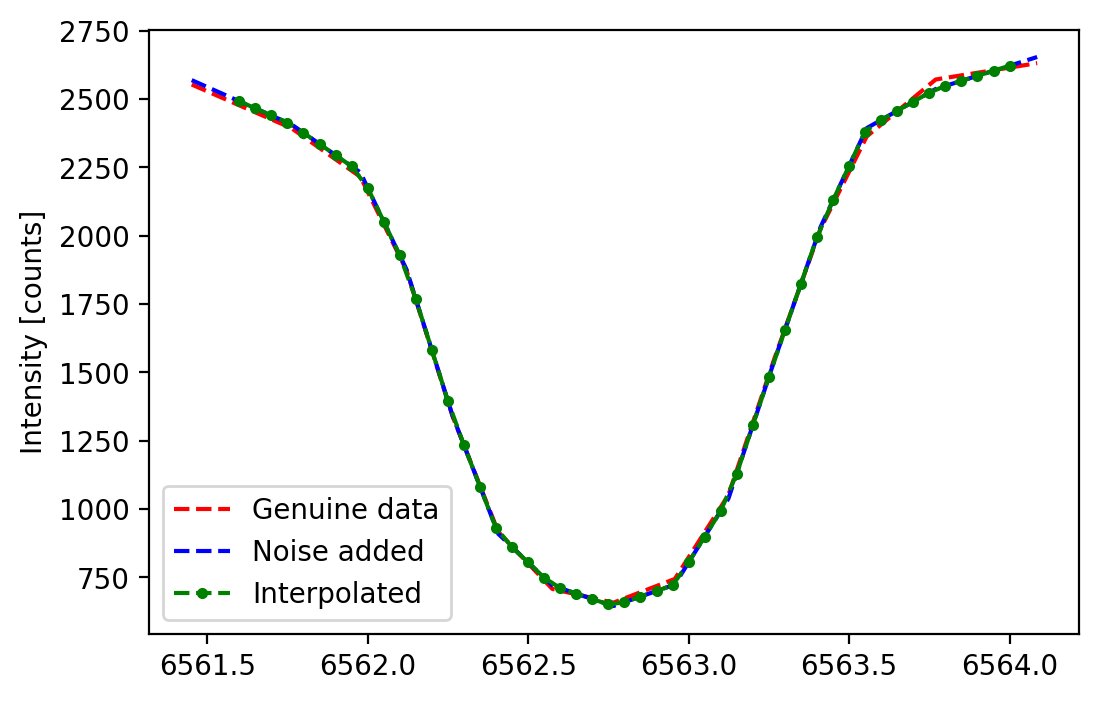

In [99]:
intensityFile = '../comps_data/average_spectral_profiles/H-alpha.txt'
waveFile      = '../comps_data/average_spectral_profiles/H-alpha_waves.txt'
intensity   = np.loadtxt(intensityFile).transpose()
waves       = np.loadtxt(waveFile).transpose() + waveHa

plt.figure(dpi=200, figsize=(6,4))

plt.plot(waves, intensity, 'r--', label='Genuine data')

# Add some noise 
noised = [np.sqrt(el/ADU) for el in intensity]
noise = [np.random.normal(0,scale=el) for el in noised] 
print(noise)

noisyI = noise + intensity
plt.plot(waves, noisyI, 'b--', label='Noise added')



#interpolate on regular 0.05Å grid 

reg_grid_waves = np.linspace(waveHa - 1.2, waveHa + 1.2, num=49)
reg_grid_I     = np.interp(reg_grid_waves, waves, noisyI)
plt.plot(reg_grid_waves, reg_grid_I, 'g.--', label='Interpolated')
plt.ylabel('Intensity [counts]')
plt.legend()
#measure some velocities 

plt.show()

plt.plot(waves, noise/noisyI)
plt.show()

In [20]:
#Generate some data and do the FFTs

n_samples     = 1000
exposure_time = 3.72

sample_data = np.zeros((n_samples, 49))

for ii in range(n_samples):
    sample_data[ii, :] = create_interp_data(intensityFile, 
                                            waveFile, reg_grid_waves)

vel_lc = [ (calc_v_lc(reg_grid_waves, sample_data[ii,:], 5, -5, 10)[0] 
            - waveHa) * cs / waveHa for 
          ii in range(n_samples)]
vel_lc = vel_lc - np.mean(vel_lc)
plt.plot(vel_lc, 'bo', alpha=0.2)
plt.xlabel('Sample #')
plt.ylabel('Velocity [km/s]')
plt.show()
print(f'The standard deviation of the dataset is {np.std(vel_lc)}')
FFT = np.abs(np.fft.rfft(vel_lc))**2
FFT[0] = 0

x_axis = np.linspace(0, 1/(2*exposure_time), num=int(n_samples/2)+1)
plt.plot(x_axis, FFT/n_samples/(2*exposure_time),'ro')
plt.yscale('log')
plt.show()

IndexError: invalid index to scalar variable.

In [ ]:
#Generate some data and do the FFTs

n_samples = 1000
sample_data = np.zeros((n_samples, 49))

for ii in range(n_samples):
    sample_data[ii, :] = create_interp_data(intensityFile, 
                                            waveFile, reg_grid_waves)

vel_cog = [ (calc_v_cog(reg_grid_waves[2:-2], sample_data[ii, 2:-2])
            - waveHa) / waveHa * cs for ii in range(n_samples)]

vel_cog = vel_cog - np.mean(vel_cog)
vel_cog = [el if (np.abs(el) < 2) else 0 for el in vel_cog ]
plt.figure(dpi=250)
plt.title('COG synthetic velocity')
plt.plot(vel_cog, 'b.')
plt.xlabel('Sample #')
plt.ylabel('Velocity [km/s]')
plt.show()
print(f'The variance of the velocity series is {np.std(vel_cog)}')
# print(f'The formatted wave grid is {reg_grid_waves}')
FFT_cog    = (np.abs(np.fft.rfft(vel_cog)))**2
FFT_cog[0] = 0
plt.figure(dpi=250)
x_axis = np.linspace(0, 1/(2*exposure_time), num=int(n_samples/2)+1)
plt.plot(x_axis, FFT_cog/n_samples/(2*3.28), 'ro')
plt.ylabel('Power [$km^2.s^{-2}.Hz^{-1}$]')

plt.yscale('log')
plt.show()

np.savez('../comps_data/Powerspectrum_Ha_v_COG_synthetic.npz', FFT_cog/n_samples/(2*exposure_time), x_axis)

In [70]:
print(reg_grid_waves.shape)
print(sample_data.shape)

spec_profile1 = spectral_data(reg_grid_waves, sample_data[0,:], 
                              ADU, 3.3)

spec_profile1.calc_rms_vel(150, calc_v_lc, 2, -2, 9)

(49,)
(1000, 49)


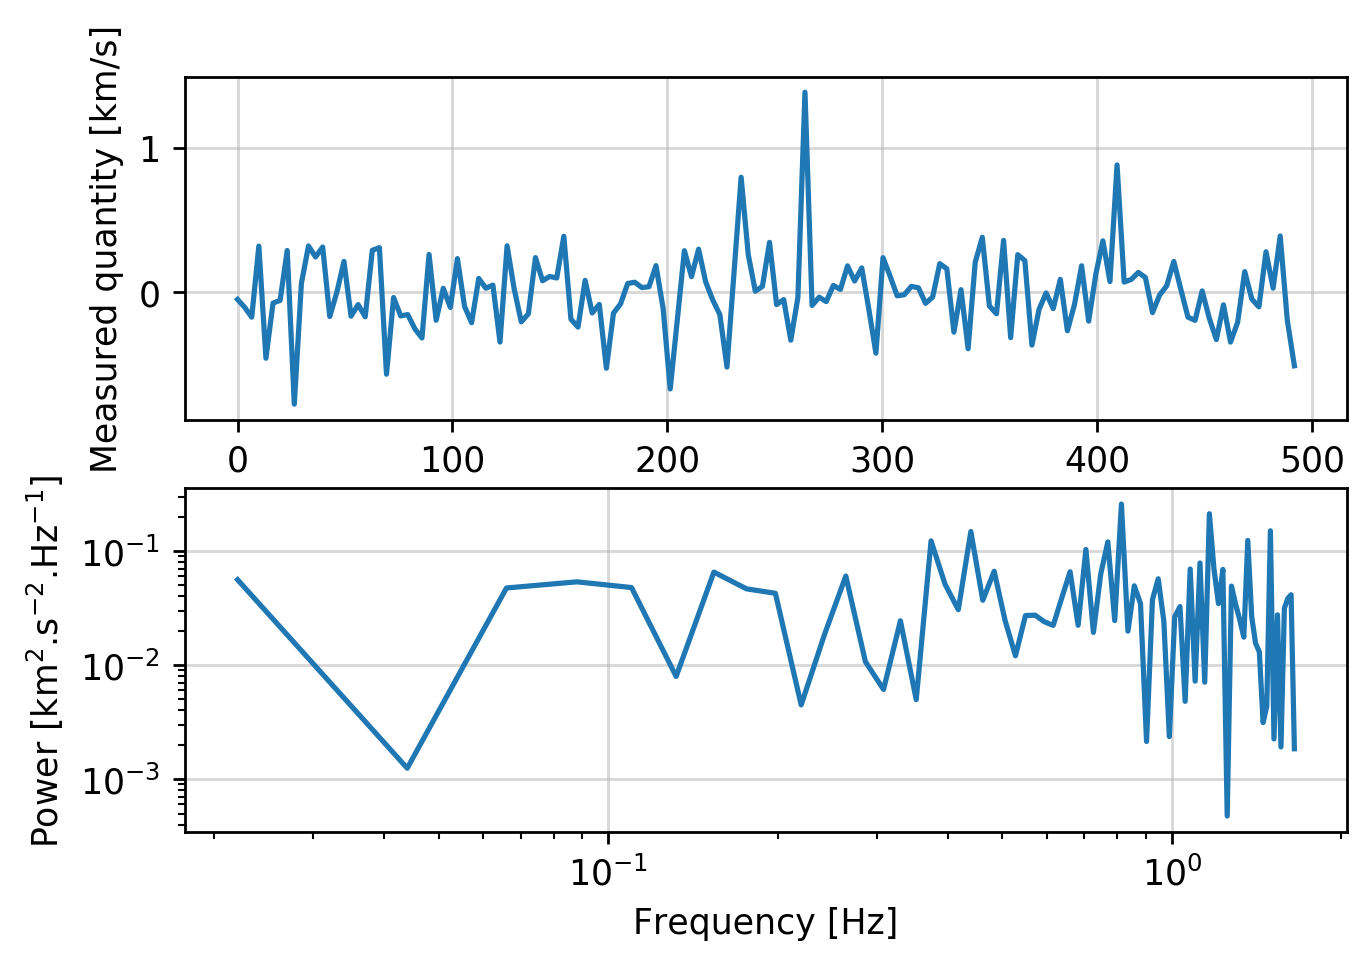

In [71]:
spec_profile1.plot_results_vel()

### Calculate the different areas of the FOV power spectra level:

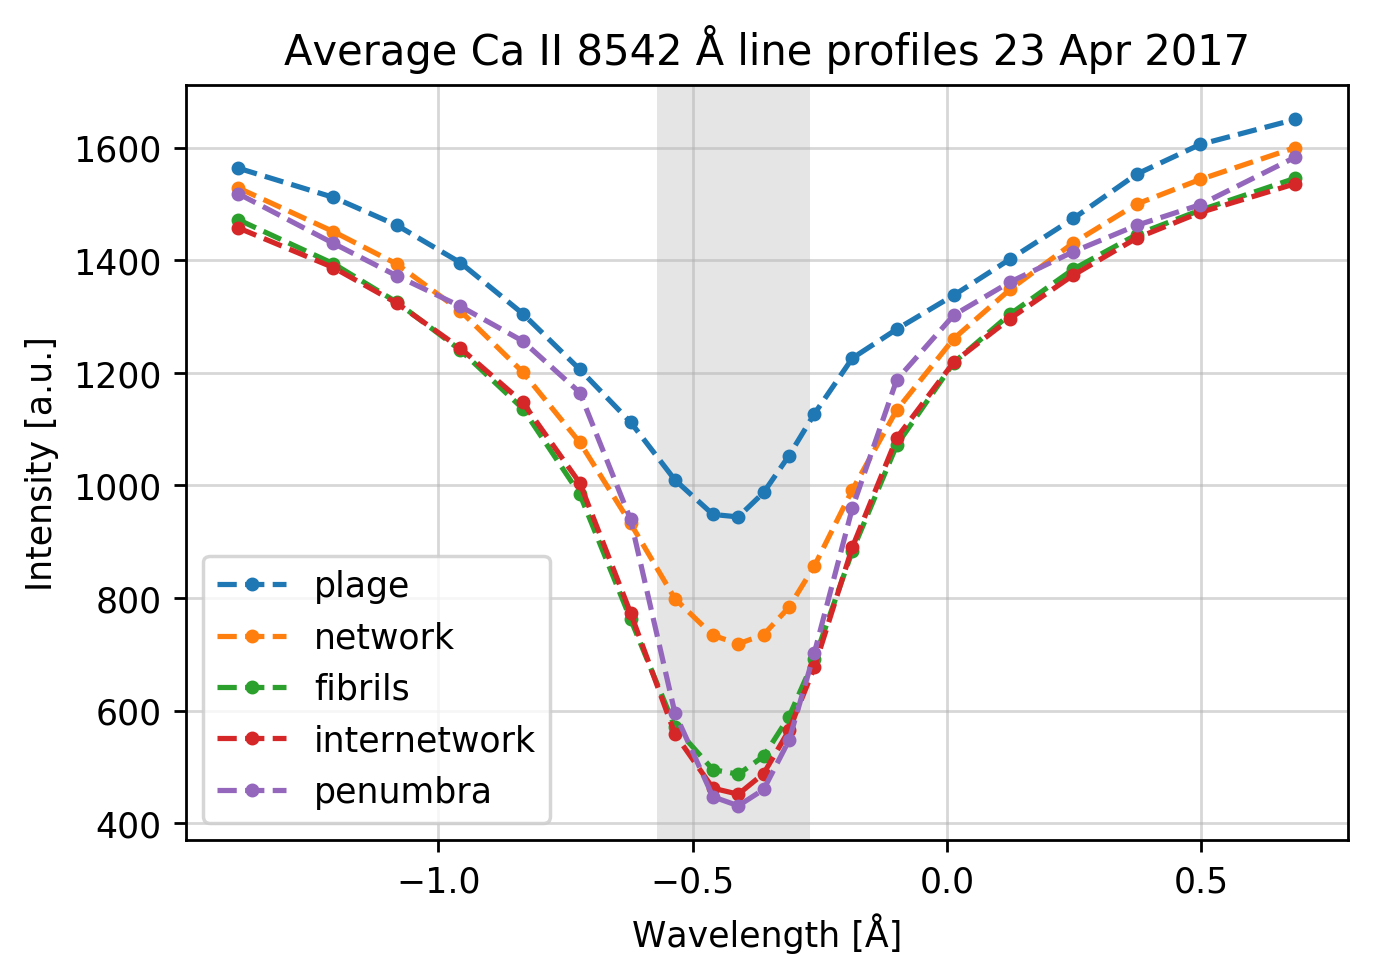

In [225]:
data_dir = ('/Users/molnarad/CU_Boulder/Work/Chromospheric_business/'
            + 'Comps_2/comps_data/IBIS/')
dx = 50

ROS = ["plage", "network", "fibrils", "internetwork", "penumbra"]
N_samples = 150
cadence   = 1/3.5
dl        = 0.05 # Å is the spacing of the 
v_signal  = np.zeros((len(ROS), int(N_samples)))
freq      = np.zeros(int(N_samples/2 + 1))
Pxx       = np.zeros((len(ROS), int(N_samples/2 + 1)))

masks = np.load(data_dir + 'Masks_FOV2.npz')

fig, ax = plt.subplots(1)
fig.set_dpi(250)

for el in range(len(ROS)):
    mask = masks[ROS[el]][dx:-dx, dx:-dx]
    
    aa = io.readsav(data_dir+'CaII8542_profiles_fast.sav')
    I = aa["profiles"][:, dx:-dx, dx:-dx]
    waves = aa['waves']
    waves_1 = np.append(waves, waves[-1]+waves[1]-waves[0])
    
    mask_zeroes = count_zeroes_in_array(mask)
    coeff_zeroes = mask.shape[0]**2 /(mask.shape[0]**2 - mask_zeroes)
    
    I_masked = [el * mask for el in I]
    I_mean = [np.mean(ell) * coeff_zeroes for ell in I_masked]

    ax.plot(waves_1, I_mean, '.--', label=ROS[el])

    spec_profile1 = spectral_data(waves_1+8542.1, I_mean, 
                              ADU, cadence, dl)

    spec_profile1.calc_rms_vel(150, calc_v_lc, 2, -2, 7)
    #spec_profile1.plot_results_vel()
    
    v_signal[el, :] = spec_profile1.velocity
    Pxx[el, :]      = spec_profile1.Pxx / 1000
    freq           = spec_profile1.ff * 1000
    
ax.grid(alpha=0.5)
rect = patches.Rectangle((-0.57, 100), .30, 2000,
                         linewidth=0, edgecolor='none', 
                         facecolor='gray', alpha=0.2) 
ax.add_patch(rect)
ax.set_title("Average Ca II 8542 Å line profiles 23 Apr 2017")
ax.set_xlabel("Wavelength [Å]")
ax.set_ylabel("Intensity [a.u.]")
ax.legend()

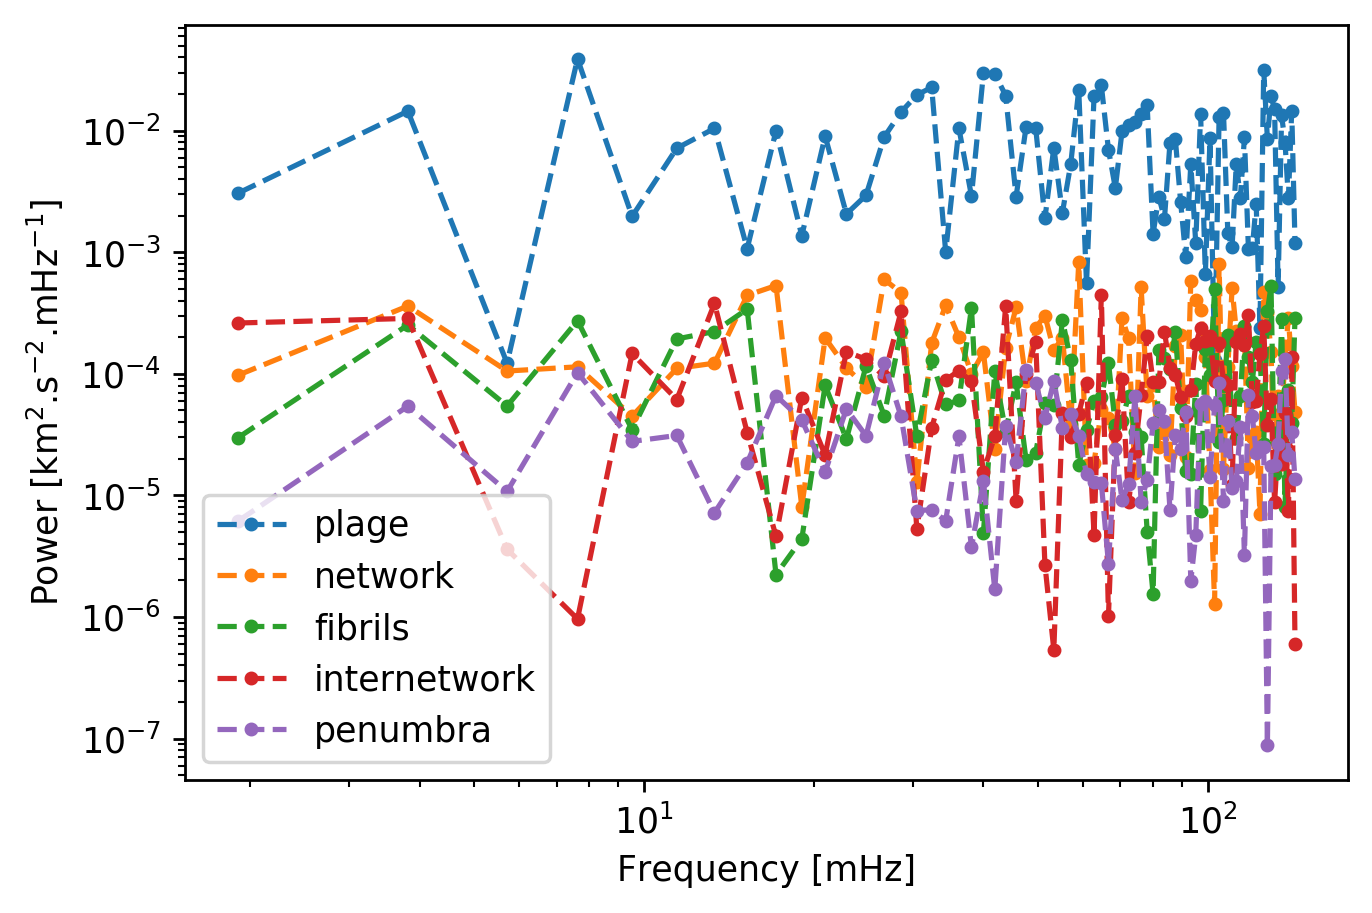

In [204]:
plt.figure(dpi=250)
plt.xlabel("Frequency [mHz]")
plt.ylabel("Power [km$^2$.s$^{-2}$.mHz$^{-1}$]")

for el in range(len(ROS)):
    plt.loglog(freq[1:], Pxx[el, 1:], '.--', label=ROS[el])
    
plt.legend()

### Calculate the distribution of the noise

In [218]:




def compute_noise():
    ROS = ["plage", "network", "fibrils", "internetwork", "penumbra"]
    data_dir = ('/Users/molnarad/CU_Boulder/Work/Chromospheric_business/'
            + 'Comps_2/comps_data/IBIS/')
    N_samples = 150
    dx = 50
    cadence   = 1/3.5
    dl        = 0.05 # Å is the spacing of the 
    freq      = np.linspace(0, cadence/2, num = int(N_samples/2 + 1))
    filename  = 'CaII8542_profiles_fast.sav'
    Pxx       = np.zeros((len(ROS), int(N_samples/2 + 1)))
    masks = np.load(data_dir + 'Masks_FOV2.npz')

    for el in range(len(ROS)):
        mask = masks[ROS[el]][dx:-dx, dx:-dx]
        
        aa = io.readsav(data_dir+filename)
        I = aa["profiles"][:, dx:-dx, dx:-dx]
        
        waves = aa['waves']
        waves_1 = np.append(waves, waves[-1]+waves[1]-waves[0])
        
        mask_zeroes = count_zeroes_in_array(mask)
        coeff_zeroes = mask.shape[0]**2 /(mask.shape[0]**2 - mask_zeroes)
        
        I_masked = [el * mask for el in I]
        I_mean = [np.mean(ell) * coeff_zeroes for ell in I_masked]
    
        #plt.plot(waves_1, I_mean, '.--', label=ROS[el])
    
        spec_profile1 = spectral_data(waves_1+8542.1, I_mean, 
                                  ADU, cadence, dl)
    
        spec_profile1.calc_rms_vel(150, calc_v_lc, 2, -2, 7)
        #spec_profile1.plot_results_vel()
        
        Pxx[el, :]      = spec_profile1.Pxx / 1000
    
    return Pxx

    
N_trials = 10

#Pxx = compute_noise()
#print(Pxx)

Pxx = Parallel(n_jobs=4)(delayed(compute_noise)() 
                         for el in range(N_trials))
    
    

KeyboardInterrupt: 

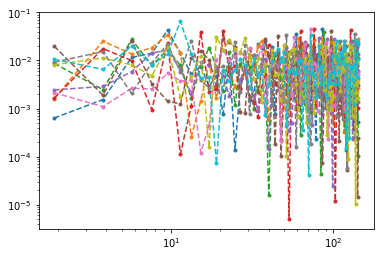

In [209]:
for el in range(N_trials):
    plt.loglog(freq[1:], Pxx[el, 0, 1:], '.--', label=ROS[0])
